training data points: 1212
validation data points: 135
testing data points: 450
Label Spreading model: 40 labeled & 300 unlabeled points (340 total)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        27
           1       0.82      1.00      0.90        37
           2       1.00      0.86      0.92        28
           3       1.00      0.80      0.89        35
           4       0.92      1.00      0.96        24
           5       0.74      0.94      0.83        34
           6       0.89      0.96      0.92        25
           7       0.94      0.89      0.91        35
           8       1.00      0.68      0.81        31
           9       0.81      0.88      0.84        24

    accuracy                           0.90       300
   macro avg       0.91      0.90      0.90       300
weighted avg       0.91      0.90      0.90       300

Confusion matrix
[[27  0  0  0  0  0  0  0  0  0]
 [ 0 37  0  0  0  0  0  0  0  0]
 [ 0  1 2

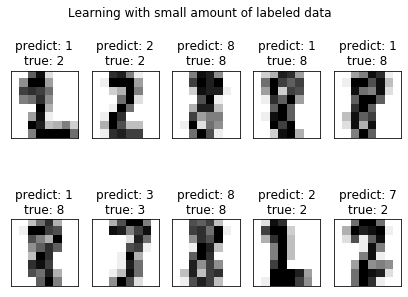

In [1]:
# -*- coding: utf-8 -*-
"""lab3.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1KTjeb3kVB-q7wsuU4R4is0VrtYMqbimu
"""

# K-Nearest Neighbor Classification

from __future__ import print_function
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import datasets
from skimage import exposure
import numpy as np
from timeit import default_timer as timer
from sklearn.semi_supervised import LabelSpreading
from scipy import stats
# load the MNIST digits dataset
mnist = datasets.load_digits()

# Training and testing split,
# 75% for training and 25% for testing
(trainData, testData, trainLabels, testLabels) = train_test_split(np.array(mnist.data), mnist.target, test_size=0.25, random_state=42)

# take 10% of the training data and use that for validation
(trainData, valData, trainLabels, valLabels) = train_test_split(trainData, trainLabels, test_size=0.1, random_state=84)

# Checking sizes of each data split
print("training data points: {}".format(len(trainLabels)))
print("validation data points: {}".format(len(valLabels)))
print("testing data points: {}".format(len(testLabels)))

rng = np.random.RandomState(2)
indices = np.arange(len(mnist.data))
rng.shuffle(indices)

X = mnist.data[indices[:340]]
y = mnist.target[indices[:340]]
images = mnist.images[indices[:340]]

n_total_samples = len(y)
n_labeled_points = 40

indices = np.arange(n_total_samples)

unlabeled_set = indices[n_labeled_points:]

# #############################################################################
# Shuffle everything around
y_train = np.copy(y)
y_train[unlabeled_set] = -1

# #############################################################################
# Learn with LabelSpreading
lp_model = LabelSpreading(gamma=.25, max_iter=20)
lp_model.fit(X, y_train)
predicted_labels = lp_model.transduction_[unlabeled_set]
true_labels = y[unlabeled_set]

cm = confusion_matrix(true_labels, predicted_labels, labels=lp_model.classes_)

print("Label Spreading model: %d labeled & %d unlabeled points (%d total)" %
      (n_labeled_points, n_total_samples - n_labeled_points, n_total_samples))

print(classification_report(true_labels, predicted_labels))

print("Confusion matrix")
print(cm)

# #############################################################################
# Calculate uncertainty values for each transduced distribution
pred_entropies = stats.distributions.entropy(lp_model.label_distributions_.T)

# #############################################################################
# Pick the top 10 most uncertain labels
uncertainty_index = np.argsort(pred_entropies)[-10:]

# #############################################################################
# Plot
f = plt.figure(figsize=(7, 5))
for index, image_index in enumerate(uncertainty_index):
    image = images[image_index]

    sub = f.add_subplot(2, 5, index + 1)
    sub.imshow(image, cmap=plt.cm.gray_r)
    plt.xticks([])
    plt.yticks([])
    sub.set_title('predict: %i\ntrue: %i' % (
        lp_model.transduction_[image_index], y[image_index]))

f.suptitle('Learning with small amount of labeled data')
plt.show()